# IS460-G2 Machine Learning & Applications

## Project Topic: Classification and Prediction of Pneumonia from Chest X-Ray Images

### Naive Bayes Implementation

#### Group 7: Shaun, Shan Mei, Xiao Xiao, Xiao Fang, Matthew, Tun Hao
 
 Following the Severe Pneumonia clusters that raised questions on accuracy and precision of pneumonia diagnosis during the COVID pandemic, this project aims to accurately identify and diagnose pneumonia patients through image classification and explore other methods of building machine learning algorithms to solve the problem.
 
(https://www.straitstimes.com/singapore/health/all-pneumonia-patients-in-public-hospitals-here-being-tested-for-coronavirus-moh) 

### Install Packages

In [18]:
# # Run Once
#!pip install opencv-python
#!pip install tensorflow
#!pip install --upgrade scikit-image


import sys
print(sys.executable)

import skimage
print(skimage.__version__)


c:\Users\xfaan\Documents\GitHub\is460-project\myenv\Scripts\python.exe
0.22.0


### Import Packages

In [19]:
import os
import cv2

from tqdm import tqdm
import tensorflow as tf

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import keras 
from keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

from skimage.feature import graycomatrix, graycoprops

from scipy.stats import skew, kurtosis

### Import Dataset

In [20]:
path = "chest_xray"
folders = ['train','test','val']

pd.DataFrame(os.listdir(path),columns=['Files'])

,Files
0,chest_xray
1,test
2,train
3,val
4,__MACOSX


In [21]:
# View Image Count in Folders
dict_={'train':[],'test':[],'val':[]}
class_names = []
for i in tqdm(folders):
    path_ = os.path.join(path, i)
    
    for j in os.listdir(path_):
        if i == 'train':  # Only append class names once, assuming 'train' contains all classes
            class_names.append(j)
        dict_[i].append(len(os.listdir(os.path.join(path_, j))))

df = pd.DataFrame(dict_, index=class_names)
print(df)

100%|██████████| 3/3 [00:00<00:00, 22.34it/s]

           train  test  val
NORMAL      1341   234    8
PNEUMONIA   3875   390    8


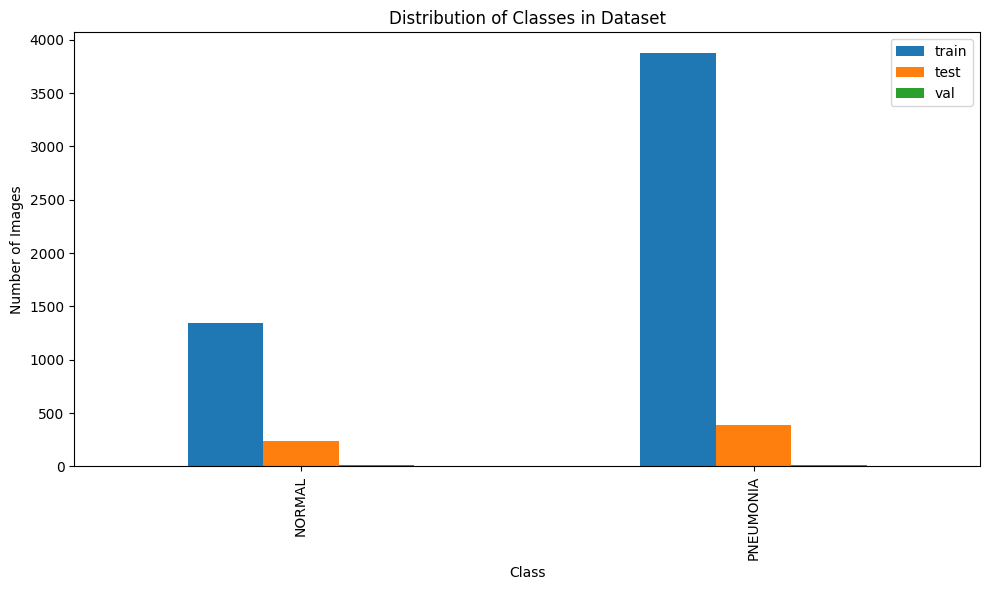

In [22]:
# Plotting the distribution
df.plot(kind='bar', figsize=(10,6))
plt.title('Distribution of Classes in Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

In [23]:
# Define Function to Identify Image Sizes
def Size(folder):
    size=[]
    path_=os.path.join(path,folder)
    for i in tqdm(os.listdir(path_)):
        path2=os.path.join(path_,i)
        for j in os.listdir(path2):
            img=cv2.imread(os.path.join(path2,j))
            size.append(img.shape)
    return pd.Series(size)

In [24]:
# View Image Sizes in Each Folder
print("Size of train: ", Size('train')); print("Size of test: ", Size('test')); print("Size of val: ",Size('val'))

100%|██████████| 2/2 [01:23<00:00, 41.53s/it]


Size of train:  0       (1858, 2090, 3)
1       (1152, 1422, 3)
2       (1434, 1810, 3)
3       (1279, 1618, 3)
4       (1125, 1600, 3)
             ...       
5211     (882, 1414, 3)
5212     (696, 1256, 3)
5213     (856, 1152, 3)
5214     (728, 1248, 3)
5215     (784, 1176, 3)
Length: 5216, dtype: object


100%|██████████| 2/2 [00:12<00:00,  6.22s/it]


Size of test:  0      (1317, 1857, 3)
1      (1509, 2111, 3)
2      (1837, 2031, 3)
3      (1326, 1663, 3)
4      (1818, 2053, 3)
            ...       
619     (856, 1120, 3)
620     (856, 1064, 3)
621    (1024, 1400, 3)
622    (1016, 1264, 3)
623    (1122, 1704, 3)
Length: 624, dtype: object


100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

Size of val:  0     (1416, 1776, 3)
1     (1040, 1272, 3)
2     (1416, 1736, 3)
3      (928, 1288, 3)
4     (1104, 1240, 3)
5     (1104, 1328, 3)
6     (1225, 1632, 3)
7     (1302, 1564, 3)
8       (592, 968, 3)
9      (712, 1072, 3)
10     (664, 1152, 3)
11     (944, 1416, 3)
12     (864, 1256, 3)
13     (656, 1016, 3)
14     (952, 1192, 3)
15    (1128, 1664, 3)
dtype: object


### Data Pre-Processing

In our Image Classification problem, Data Pre-Processing involves:  
  
- Rescaling Colors in Images 
- Resizing Images
- Normalizing Pixel Values

In [8]:
# Pre-Process Dataset
Size=80
images=[]
labels=[]

def load():
    global images
    global labels
    
    for folder in tqdm(folders):
        path_=os.path.join(path,folder)
        
        for files in os.listdir(path_):
            path2=os.path.join(path_,files)
            
            for img in os.listdir(path2):
                # Read Images
                image=cv2.imread(os.path.join(path2,img))
                # Convert BGR to RGB Color Codes
                image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                # Resize Images
                image=cv2.resize(image,(Size,Size))
                # Normalize Pixel Values (Scaling to [0, 1])
                image=image/255.0
                images.append(image)
                labels.append(files)      
load()

images=np.array(images)
labels=np.array(labels)

100%|██████████| 3/3 [01:12<00:00, 24.30s/it]


In [9]:
# Overview of Pre-Processed Data
print('Images Shape :',images.shape); print('Labels Shape :',labels.shape)

Images Shape : (5856, 80, 80, 3)
Labels Shape : (5856,)


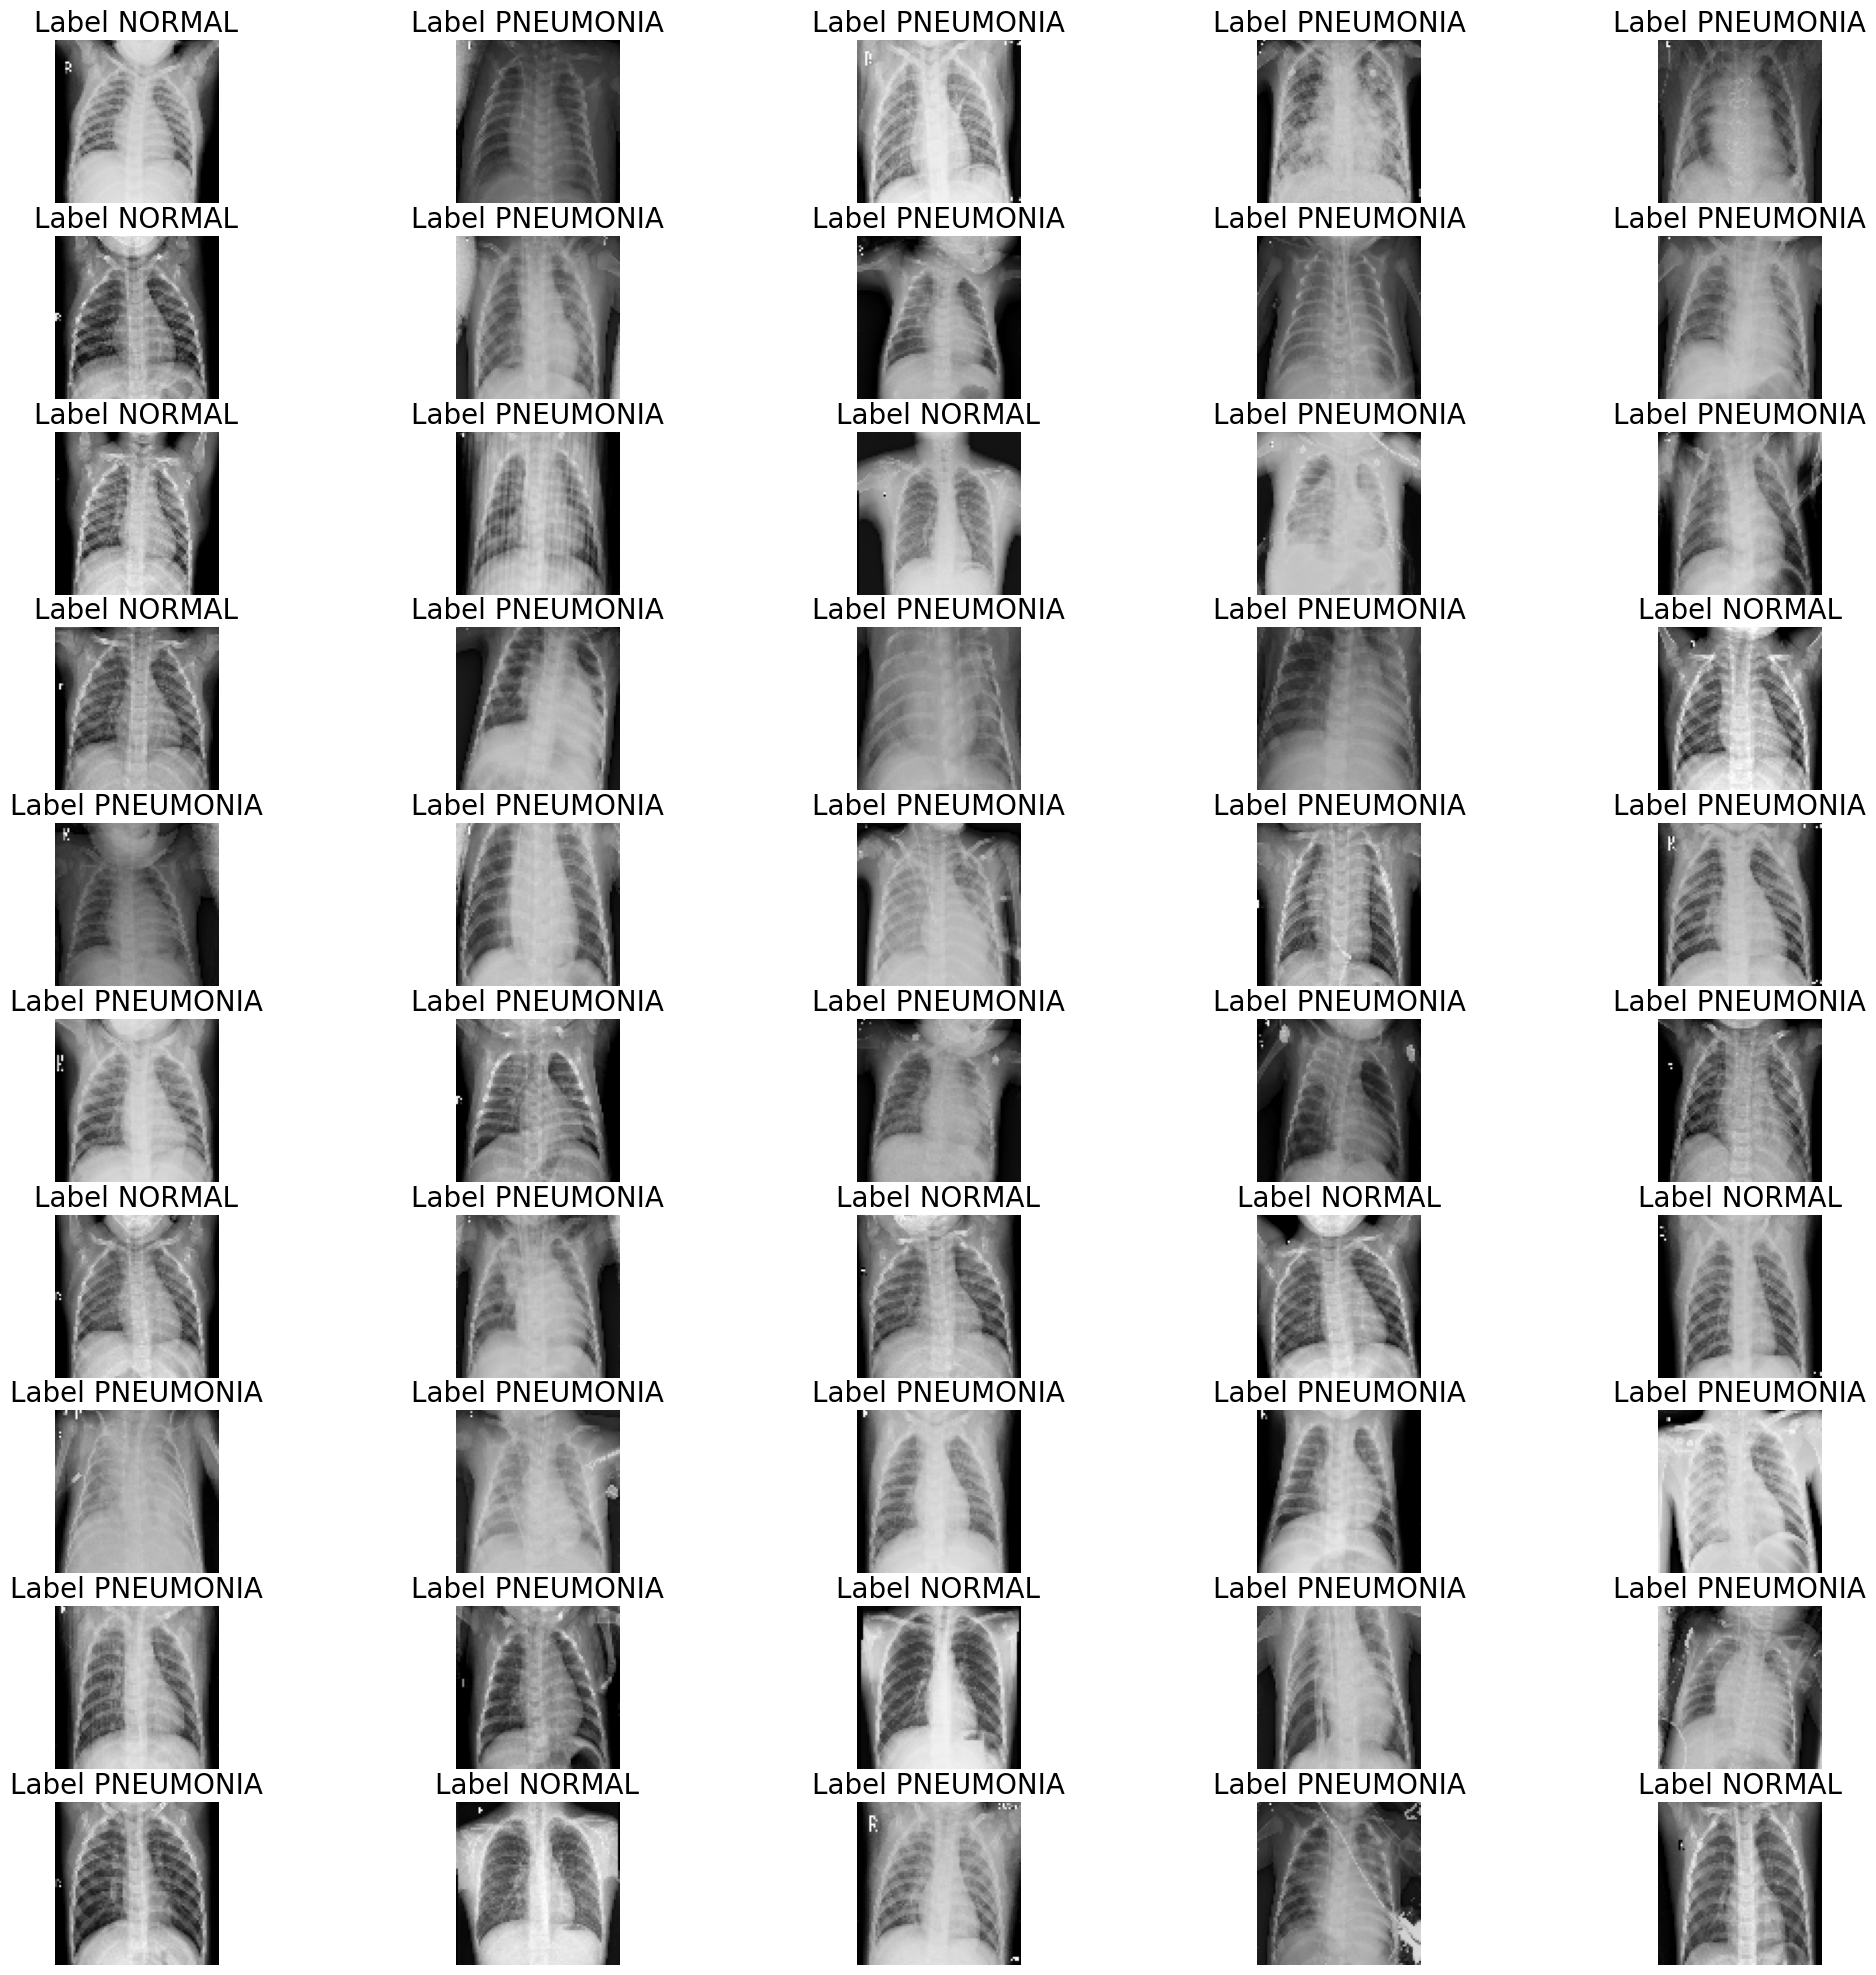

In [10]:
# Plot Pre-Processed Data
plt.figure(figsize=(25,25))
x = 1
for i in np.random.randint(0,len(images),50):
    plt.subplot(10, 5, x)
    plt.imshow(images[i])
    plt.title(f'Label {labels[i]}', fontsize=20)
    plt.axis('off')    
    x += 1

### EDA

To build a Naive Bayes Model in this problem, we will need to create numerical features based off these images. In this method, we assume grayscale images _(8-bit range)_ because they are widely used for texture analysis and basic feature extraction in image processing and computer vision. 

Considering that our dataset are X-Ray Images of Lungs, we build a pandas DataFrame with the following features from these images:  
- Histogram of Pixel Intensities - Represents distribution of pixel intensities in the image  
- Texture Features (Gray-Level Co-Occurence Matrix) - Measures texture patterns in the X-Ray image  
- Statistical Features - Compute statistics such as mean, standard deviation, skewness, and kurtosis of pixel intensities

#### Histogram of Pixel Intensities

In [11]:
intensity_histograms = []

for image in images:
    
    # Convert the image data type to uint8
    image = (image * 255).astype(np.uint8)
    
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calculate Histogram of Pixel Intensities
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist = hist.flatten()
    
    # Append intensity histogram features to the list
    intensity_histograms.append(hist)
    
# Create Pandas DataFrame with intensity histogram features
nb_histogram = pd.DataFrame(intensity_histograms)

print(nb_histogram.head())

     0     1     2     3     4     5     6     7     8     9    ...  246  247  \
0   32.0   4.0   4.0   3.0  11.0   7.0  12.0  14.0  21.0  23.0  ...  0.0  1.0   
1  475.0  14.0  14.0  12.0  18.0  16.0  12.0  14.0  16.0  15.0  ...  0.0  1.0   
2  700.0  59.0  34.0  30.0  24.0  29.0  11.0  10.0   2.0   2.0  ...  0.0  0.0   
3   72.0  24.0  20.0  16.0  31.0  31.0  30.0  34.0  28.0  33.0  ...  1.0  0.0   
4  748.0  24.0  20.0  15.0  16.0  18.0  18.0   8.0  13.0  12.0  ...  0.0  1.0   

   248  249  250  251  252  253  254  255  
0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  2.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  3.0  
2  0.0  1.0  0.0  1.0  0.0  3.0  0.0  1.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  1.0  4.0  
4  0.0  1.0  0.0  0.0  1.0  0.0  1.0  4.0  

[5 rows x 256 columns]


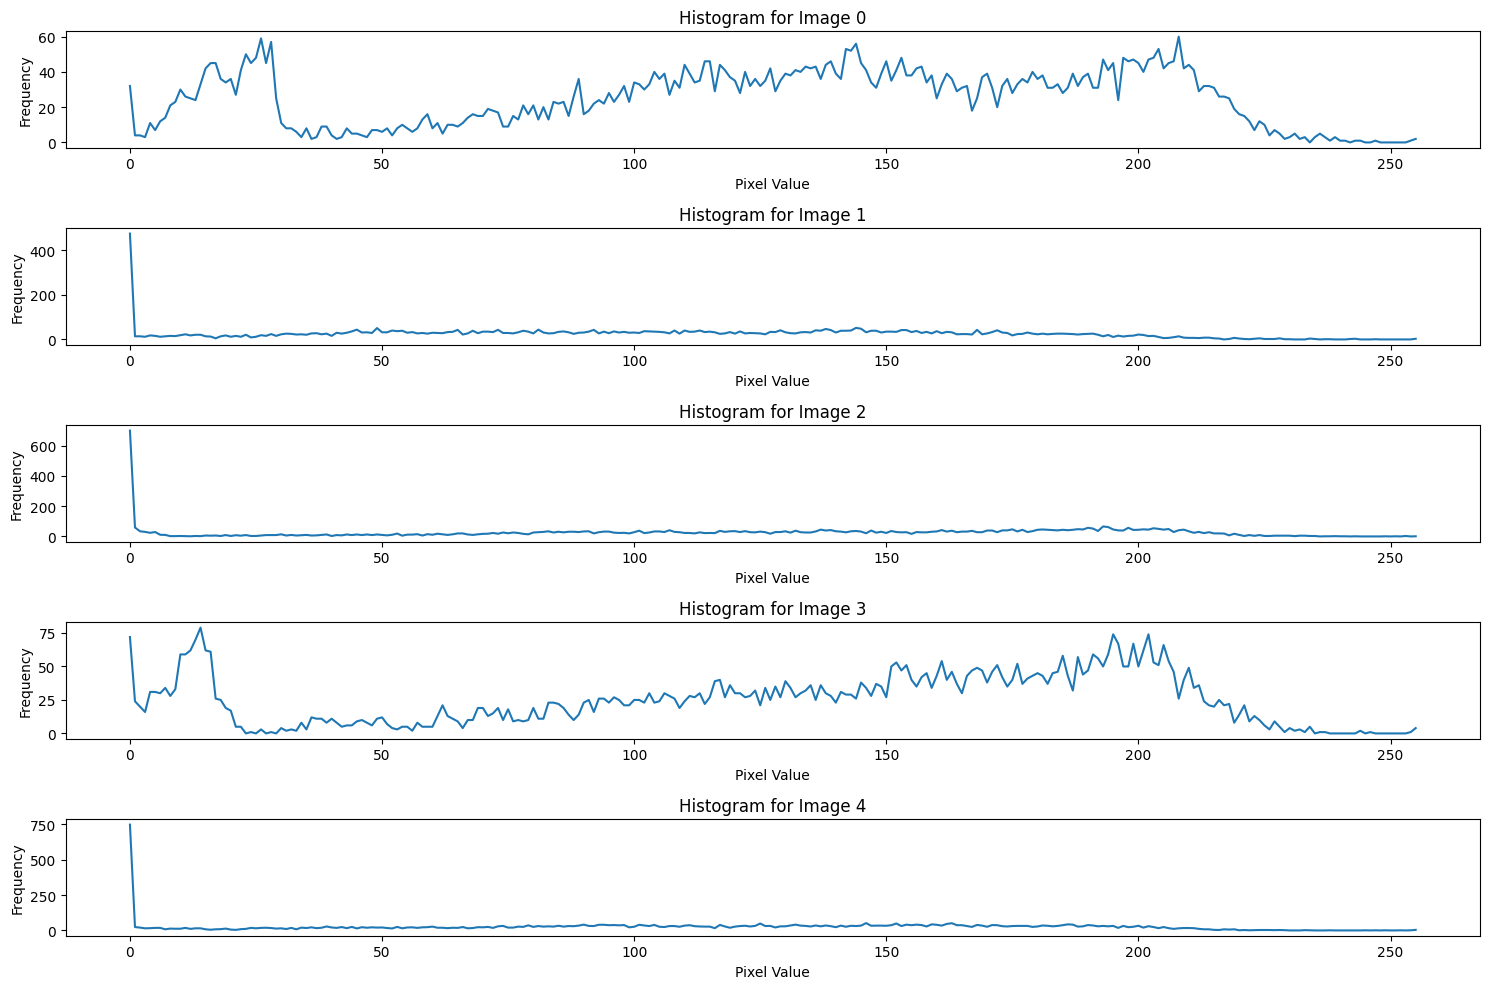

In [12]:
# Plotting histograms for the first few images
num_images_to_plot = 5  

plt.figure(figsize=(15, 10))

for idx in range(num_images_to_plot):
    plt.subplot(num_images_to_plot, 1, idx + 1)
    plt.plot(nb_histogram.iloc[idx])
    plt.title(f'Histogram for Image {idx}')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

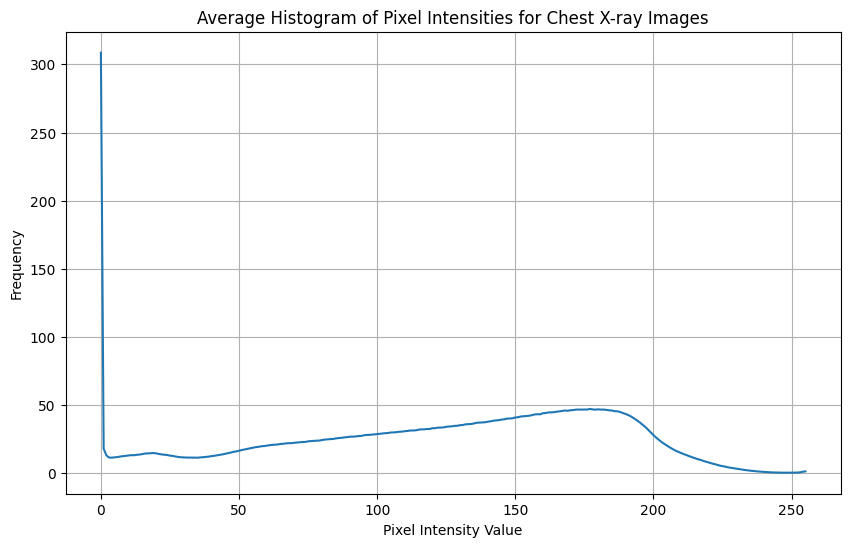

Average Mean Intensity Across All Images: 25.00
Average Median Intensity Across All Images: 25.00
Standard Deviation of Intensities Across All Images: 0.00


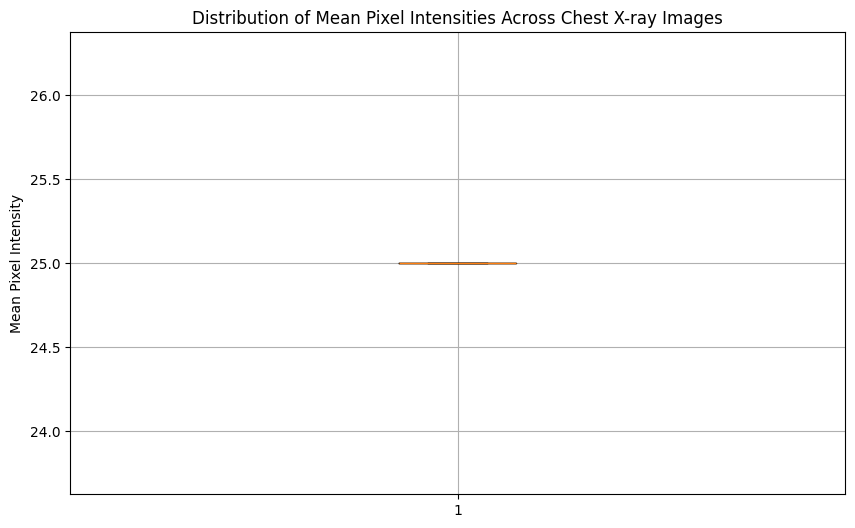

In [13]:
import matplotlib.pyplot as plt

# Averaging histograms over all images to get a general sense
avg_histogram = nb_histogram.mean(axis=0)

# Plotting the average histogram
plt.figure(figsize=(10, 6))
plt.plot(avg_histogram)
plt.title('Average Histogram of Pixel Intensities for Chest X-ray Images')
plt.xlabel('Pixel Intensity Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Statistical measures
mean_intensity = nb_histogram.mean(axis=1).mean()
median_intensity = nb_histogram.mean(axis=1).median()
std_intensity = nb_histogram.mean(axis=1).std()

print(f"Average Mean Intensity Across All Images: {mean_intensity:.2f}")
print(f"Average Median Intensity Across All Images: {median_intensity:.2f}")
print(f"Standard Deviation of Intensities Across All Images: {std_intensity:.2f}")

# Bonus: Box plot to understand intensity distribution variability across images
plt.figure(figsize=(10, 6))
plt.boxplot(nb_histogram.mean(axis=1))
plt.title('Distribution of Mean Pixel Intensities Across Chest X-ray Images')
plt.ylabel('Mean Pixel Intensity')
plt.grid(True)
plt.show()


#### Texture Features (Gray-Level Co-Occurence Matrix)

In [14]:
from skimage.feature import graycomatrix, graycoprops

glcm_contrast = []
glcm_correlation = []

for image in images:
    
    # Convert the image data type to uint8
    image = (image * 255).astype(np.uint8)
    
    # Convert the color image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate GLCM
    glcm = graycomatrix(gray_image, [1], [0], symmetric=True, normed=True)

    # Calculate GLCM features (contrast and correlation)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    # Append GLCM features and label to respective lists
    glcm_contrast.append(contrast)
    glcm_correlation.append(correlation)

# Create a Pandas DataFrame with GLCM features and labels
import pandas as pd

nb_glcm = pd.DataFrame({'GLCM_Contrast': glcm_contrast, 'GLCM_Correlation': glcm_correlation})

print(nb_glcm)

      GLCM_Contrast  GLCM_Correlation
0        390.416139          0.948514
1        499.194620          0.928829
2        358.495253          0.960998
3        325.409335          0.960163
4        625.791139          0.924702
...             ...               ...
5851     522.671994          0.920236
5852     449.555063          0.929513
5853     308.528165          0.946911
5854     239.602215          0.958970
5855     338.477848          0.970692

[5856 rows x 2 columns]


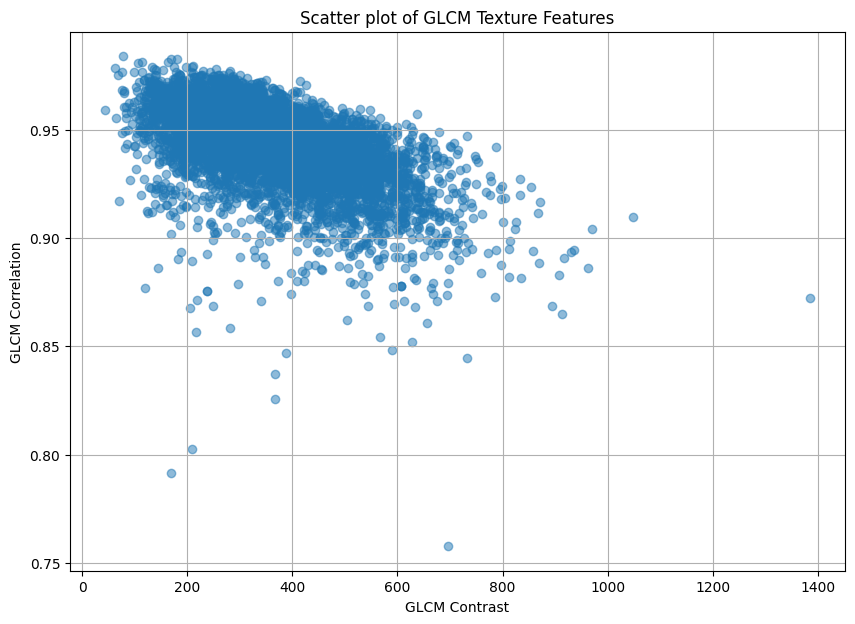

In [15]:
# Visualization
plt.figure(figsize=(10, 7))
plt.scatter(nb_glcm['GLCM_Contrast'], nb_glcm['GLCM_Correlation'], alpha=0.5)
plt.title('Scatter plot of GLCM Texture Features')
plt.xlabel('GLCM Contrast')
plt.ylabel('GLCM Correlation')
plt.grid(True)
plt.show()

In [16]:
# Compute summary statistics for GLCM Contrast
mean_contrast = nb_glcm['GLCM_Contrast'].mean()
median_contrast = nb_glcm['GLCM_Contrast'].median()
std_contrast = nb_glcm['GLCM_Contrast'].std()
min_contrast = nb_glcm['GLCM_Contrast'].min()
max_contrast = nb_glcm['GLCM_Contrast'].max()

# Compute summary statistics for GLCM Correlation
mean_correlation = nb_glcm['GLCM_Correlation'].mean()
median_correlation = nb_glcm['GLCM_Correlation'].median()
std_correlation = nb_glcm['GLCM_Correlation'].std()
min_correlation = nb_glcm['GLCM_Correlation'].min()
max_correlation = nb_glcm['GLCM_Correlation'].max()

# Print the summary
print("GLCM Contrast Summary:")
print(f"Mean: {mean_contrast:.2f}")
print(f"Median: {median_contrast:.2f}")
print(f"Standard Deviation: {std_contrast:.2f}")
print(f"Min: {min_contrast:.2f}")
print(f"Max: {max_contrast:.2f}")
print("\nGLCM Correlation Summary:")
print(f"Mean: {mean_correlation:.2f}")
print(f"Median: {median_correlation:.2f}")
print(f"Standard Deviation: {std_correlation:.2f}")
print(f"Min: {min_correlation:.2f}")
print(f"Max: {max_correlation:.2f}")


GLCM Contrast Summary:
Mean: 365.45
Median: 353.76
Standard Deviation: 141.33
Min: 44.17
Max: 1384.35

GLCM Correlation Summary:
Mean: 0.94
Median: 0.94
Standard Deviation: 0.02
Min: 0.76
Max: 0.98


In [17]:
import seaborn as sns

# Convert your labels into a DataFrame
df_labels = pd.DataFrame({'Diagnosis': labels})

# Merge the GLCM features dataframe with the diagnosis labels
df = pd.concat([nb_glcm, df_labels], axis=1)

# Calculate the correlation matrix for GLCM features and labels
correlation_matrix = df.corr()

# Since 'labels' are categorical, we'll use one hot encoding or dummy encoding to make it numerical before finding correlation
encoded_labels = pd.get_dummies(df_labels['Diagnosis'])

# Add the GLCM features to this encoded DataFrame
df_encoded = pd.concat([nb_glcm, encoded_labels], axis=1)

# Calculate correlation with encoded labels
correlation_encoded = df_encoded.corr()

# Let's say you have two categories: "NORMAL" and "PNEUMONIA". Extract their correlations
correlation_with_normal = correlation_encoded["NORMAL"].sort_values(ascending=False)
correlation_with_pneumonia = correlation_encoded["PNEUMONIA"].sort_values(ascending=False)

print("Correlation with NORMAL:")
print(correlation_with_normal)

print("\nCorrelation with PNEUMONIA:")
print(correlation_with_pneumonia)


ValueError: could not convert string to float: 'NORMAL'

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the correlation data
correlation_data = {
    "GLCM_Contrast": [0.420461, -0.420461],
    "GLCM_Correlation": [-0.223588, 0.223588],
    "NORMAL": [1.0, -1.0],
    "PNEUMONIA": [-1.0, 1.0]
}

# Create a DataFrame
df = pd.DataFrame(correlation_data, index=["NORMAL", "PNEUMONIA"])

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap
sns.heatmap(df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)

# Set labels and title
plt.xlabel('Features')
plt.ylabel('Diagnosis')
plt.title('GLCM Feature Correlation with Diagnosis')

# Show the plot
plt.show()


#### Statistical Features

In [ ]:
# Statistical Features
means = []
stds = []
skewnesses = []
kurtoses = []

for image in images:
    
    # Convert the image data type to uint8
    image = (image * 255).astype(np.uint8)
    
    # Calculate statistics of pixel intensities
    mean = np.mean(image)
    std = np.std(image)
    skewness = np.mean(((image - mean) / std) ** 3)
    kurtosis = np.mean(((image - mean) / std) ** 4)

    # Append statistical features and label to respective lists
    means.append(mean)
    stds.append(std)
    skewnesses.append(skewness)
    kurtoses.append(kurtosis)

# Create a Pandas DataFrame with statistical features and labels
import pandas as pd

nb_stat = pd.DataFrame({'Mean': means, 'Std': stds, 'Skewness': skewnesses, 'Kurtosis': kurtoses})

print(nb_stat)

In [ ]:
# Summary of the results
summary = nb_stat.describe().T

# Extracting additional statistics: median, skewness and kurtosis
summary['median'] = nb_stat.median()
summary['skew'] = nb_stat.skew()
summary['kurt'] = nb_stat.kurt()

# Displaying the summary
print(summary)

#### Concatenate Numerical Features with Label

In [ ]:
data_nb = pd.concat([nb_stat, nb_glcm, nb_histogram], axis=1)
data_nb['Label'] = labels

print(data_nb.columns.tolist()); print(data_nb.dtypes)

#### Data Pre-processing

### Texture-based Feature Engineering

In [ ]:
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage import io
import os
import pandas as pd
from tqdm import tqdm

def extract_glcm_features(image_path):
    # Read the image
    image = io.imread(image_path)
    
    # Check the number of channels
    if len(image.shape) == 3 and image.shape[2] == 3:  # RGB Image
        gray_image = rgb2gray(image)
    elif len(image.shape) == 2 or (len(image.shape) == 3 and image.shape[2] == 1):  # Grayscale Image
        gray_image = image
    else:
        raise ValueError(f"Unsupported image format with shape {image.shape}")
    
    gray_image = (gray_image * 255).astype('uint8')
    
    # Calculate the greycomatrix
    glcm = graycomatrix(gray_image, [1], [0],  symmetric=True, normed=True)
    
    # Extract features from the GLCM
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    return contrast, energy, homogeneity


path = "chest_xray" 
folders = ['train', 'test', 'val']

data = {
    'Image': [],
    'Class': [],
    'Dataset': [],
    'Contrast': [],
    'Energy': [],
    'Homogeneity': []
}

for dataset in tqdm(folders):
    dataset_path = os.path.join(path, dataset)
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            contrast, energy, homogeneity = extract_glcm_features(image_path)
            data['Image'].append(image_name)
            data['Class'].append(class_name)
            data['Dataset'].append(dataset)
            data['Contrast'].append(contrast)
            data['Energy'].append(energy)
            data['Homogeneity'].append(homogeneity)

df_glcm = pd.DataFrame(data)
print(df_glcm)


### Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

# Define your data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=40,          # Randomly rotate images in the range (0-40 degrees)
    width_shift_range=0.2,      # Randomly shift images horizontally by 20% of the width
    height_shift_range=0.2,     # Randomly shift images vertically by 20% of the height
    shear_range=0.2,            # Randomly shear images
    zoom_range=0.2,             # Randomly zoom inside images
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest',        # Fill in newly created pixels, which can appear after a rotation or width/height shift
    brightness_range=[0.8, 1.2] # Randomly change brightness (80-120% of original image)
)

# Assuming you have your training images in a variable called `x_train`
# and their corresponding labels in a variable called `y_train`
# x_train = ... (your image data here, typically shaped as [num_samples, height, width, channels])
# y_train = ... (your labels here)

# Visualize some augmented images
# Taking one image from the dataset to demonstrate augmentation
img = x_train[0]  # adjust this if you have a different dataset arrangement
img = img.reshape((1,) + img.shape)

# Generate batches of augmented images from the original image
fig = plt.figure(figsize=(8, 8))
i = 0
for batch in datagen.flow(img, batch_size=1):
    plt.subplot(3, 3, i + 1)
    plt.imshow(batch[0].astype('uint8'))
    i += 1
    if i == 9:  # display only 9 images
        break

plt.show()

# If you want to use the augmented data for training, you can do:
# train_generator = datagen.flow(x_train, y_train, batch_size=32)
# and use train_generator in model's fit_generator method.


### Dimensionality Reduction

Among the numerical features created, Column Names '0', '1'...'255' represent the Histogram of Pixel Intensities. This causes our dataset to be extremely high in dimensionality. Before conducting analysis and modelling, we attempt to reduce dimensionality by converting histogram features to features that can justify the shape of this histogram - "Hist_Skewness", "Hist_Kurtosis".

In [ ]:
data_nb[1]

In [ ]:
from scipy.stats import skew, kurtosis


histogram_features = range(256)

# Obtain Skewness of Histogram Features
data_nb['Hist_Skewness'] = data_nb[histogram_features].apply(lambda row: skew(row), axis=1)

# Obtain Kurtosis of Histogram Features
data_nb['Hist_Kurtosis'] = data_nb[histogram_features].apply(lambda row: kurtosis(row), axis=1)

# Drop Initial Histogram Features
data_nb = data_nb.drop(columns=histogram_features)

In [ ]:
# Label Encode the Target "Label"
label_encoder = LabelEncoder()

# Fit & Transform "Label"
y_encoded = label_encoder.fit_transform(data_nb['Label'])

# View mappings of encoded Labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Label Mapping: ")

for label, code in label_mapping.items():
    print(f"{label}: {code}")
    
# Fit Labelling into dataframe
data_nb["Label"] = y_encoded

data_nb

### Implementation of Gaussian Naive Bayes

To begin the Modelling, we split our data into Training, Validation and Test sets.

In [ ]:
# Define Input and Output Variables
X = data_nb.drop(columns='Label', axis=1)
y = data_nb['Label']

# Initial Train-Test Split
X_train, X_test2, y_train, y_test2 = train_test_split(X, y, test_size=0.30, random_state=460, shuffle =True)

# Further split Test data into Validation and Test Sets
X_val, X_test, y_val, y_test = train_test_split(X_test2, y_test2, test_size=0.33, random_state=460, shuffle =True)

We standardize our values to allow for easier convergence of optimization later on in the hyperparameter tuning. It also gives all the features equal importance.  
    
Furthermore, as Naive Bayes assumes that our features follow a normal distribution, standardization allows us to achieve Gaussian Assumption

In [ ]:
# Standardize features as our Output has values 0 or 1
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_val = scaler.fit_transform(X_val)

# Initialize and train the Gaussian Naive Bayes model
model = GaussianNB()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

#### Hyperparameter Tuning

While Gaussian Naive Bayes does not have any hyperparameters compared to complex models like CNN or SVM, we can use these parameters for adjustment in our Validation Set:  
1) Priors (class_priors) - this is prior probabilities for each class.  
2) Var_smoothing - controls the portion of the largest variance of all features added to the variances for calculation stablility.

In [ ]:
# Define Hyperparameter grid
param_grid = {
    'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7],
    'priors': [None, [0.5,0.5], [0.7,0.3], [0.9,0.1]]
}

# Perform Grid Search with Cross-Validation (cv=5)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best Hyperparameters
best_params = grid_search.best_params_

best_params

However, these best_params proved to have been overfitting the model. We can conclude that although Naive Bayes is not technically a very reliable model for this image classification problem, it could also be that insufficient numerical features were extracted to make an accurate prediction.

In [ ]:
# Train Model on Combined Training & Validation Data
X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

# Create a new GNB model with the tuned hyperparameters
model_tuned = GaussianNB(priors=None, var_smoothing = 1e-10)

# Train the new GNB model on the combined training and validation data
model_tuned.fit(X_train_val, y_train_val)

# Make predictions
y_pred1 = model_tuned.predict(X_test)

# Evaluate the model on the test set
accuracy1 = accuracy_score(y_test, y_pred1)
print("Accuracy on test set:", accuracy1)

#### Evaluate Model on Test Set

The evaluation will be done on a confusion matrix to visualize the Precision, Accuracy and Recall of the model.

_Evaluate initial model (Pre-Hyperparameter Tuning) with better scores on test set._

In [ ]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate metrics
TP = np.sum((y_test == 1) & (y_pred == 1))
FP = np.sum((y_test == 0) & (y_pred == 1))
TN = np.sum((y_test == 0) & (y_pred == 0))
FN = np.sum((y_test == 1) & (y_pred == 0))

# Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Precision
precision = TP / (TP + FP)

# Recall (Sensitivity)
recall = TP / (TP + FN)

# F1-Score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Test Data)')
plt.show()

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1_score)

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

_Evaluate tuned model (After Hyperparameter Tuning) with worse scores on test set._

In [ ]:
# Make predictions on the test data
y_pred_tuned = model_tuned.predict(X_test)

# Calculate metrics
TP = np.sum((y_test == 1) & (y_pred_tuned == 1))
FP = np.sum((y_test == 0) & (y_pred_tuned == 1))
TN = np.sum((y_test == 0) & (y_pred_tuned == 0))
FN = np.sum((y_test == 1) & (y_pred_tuned == 0))

# Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Precision
precision = TP / (TP + FP)

# Recall (Sensitivity)
recall = TP / (TP + FN)

# F1-Score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Test Data)')
plt.show()

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1_score)

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_tuned))